<a href="https://colab.research.google.com/github/labviaunb/pinns/blob/main/lid_driven_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Passo 1: Configurar o backend para PyTorch ---
# Garante que o DeepXDE usará o PyTorch para os cálculos.
import os
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Troca o tipo de ponto flutuante para 64 bit, originalmente é 32 bit (essa alteração é necessária)
dde.config.set_default_float('float64')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


Compiling model...
'compile' took 5.044795 s

Iniciando treinamento com Adam...
Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [9.60e-04, 2.76e-03, 1.03e-02, 3.27e-02, 1.53e-02, 4.11e-02, 1.47e-02, 7.28e-01, 2.92e-02, 2.13e-02]    [8.05e-04, 2.78e-03, 1.04e-02, 3.33e-02, 1.53e-02, 4.11e-02, 1.47e-02, 7.28e-01, 2.92e-02, 2.13e-02]    []  
1000      [2.59e-04, 2.58e-03, 5.62e-05, 1.15e-03, 2.37e-02, 1.85e-04, 1.15e-03, 2.27e-03, 5.46e-05, 2.58e-03]    [1.79e-04, 2.50e-03, 2.22e-05, 9.65e-04, 2.37e-02, 1.85e-04, 1.15e-03, 2.27e-03, 5.46e-05, 2.58e-03]    []  
2000      [2.35e-04, 2.48e-03, 1.75e-05, 1.10e-03, 2.24e-02, 1.99e-04, 1.16e-03, 2.37e-03, 3.88e-05, 2.29e-03]    [1.60e-04, 2.54e-03, 7.79e-06, 8.02e-04, 2.24e-02, 1.99e-04, 1.16e-03, 2.37e-03, 3.88e-05, 2.29e-03]    []  
30

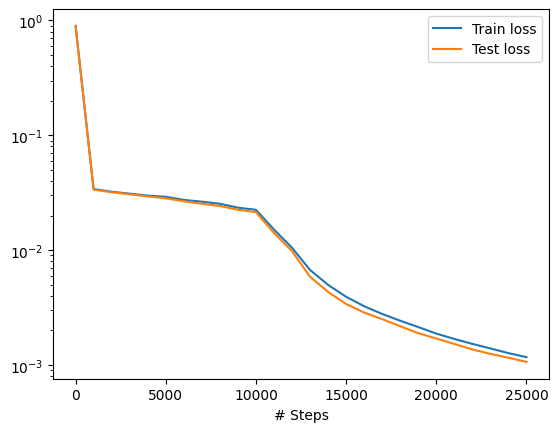

<Figure size 640x480 with 0 Axes>

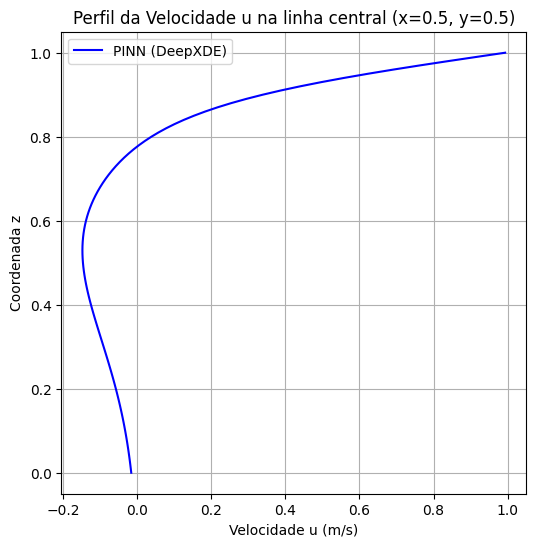

In [ ]:
# --- Passo 2: Definir os parâmetros físicos ---
# O Número de Reynolds (Re) caracteriza o escoamento.
# Para Re > 1, o escoamento é dominado pela inércia.
# A viscosidade cinemática (nu) é inversamente proporcional a Re.
Re = 100.0
nu = 1 / Re

# --- Passo 3: Definir a geometria do problema ---
# A geometria é um cubo unitário que se estende de [0,0,0] a [1,1,1].
geom = dde.geometry.Cuboid(xmin=[0, 0, 0], xmax=[1, 1, 1])

# --- Passo 4: Definir as equações de Navier-Stokes (resíduos) ---
# Esta função define as equações governantes. A rede neural será treinada
# para minimizar os resíduos destas equações, forçando-a a aprender a física.
# A entrada 'x' contém as coordenadas (x, y, z).
# A saída 'Y' contém as variáveis da solução (u, v, w, p).
def navier_stokes_3d(x, Y):
    u, v, w, p = Y[:, 0:1], Y[:, 1:2], Y[:, 2:3], Y[:, 3:4]

    # Calculando as derivadas necessárias usando diferenciação automática do DeepXDE.
    du_x = dde.grad.jacobian(Y, x, i=0, j=0)
    du_y = dde.grad.jacobian(Y, x, i=0, j=1)
    du_z = dde.grad.jacobian(Y, x, i=0, j=2)

    dv_x = dde.grad.jacobian(Y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, x, i=1, j=1)
    dv_z = dde.grad.jacobian(Y, x, i=1, j=2)

    dw_x = dde.grad.jacobian(Y, x, i=2, j=0)
    dw_y = dde.grad.jacobian(Y, x, i=2, j=1)
    dw_z = dde.grad.jacobian(Y, x, i=2, j=2)

    dp_x = dde.grad.jacobian(Y, x, i=3, j=0)
    dp_y = dde.grad.jacobian(Y, x, i=3, j=1)
    dp_z = dde.grad.jacobian(Y, x, i=3, j=2)

    # Derivadas de segunda ordem (laplacianos)
    du_xx = dde.grad.hessian(Y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, x, component=0, i=1, j=1)
    du_zz = dde.grad.hessian(Y, x, component=0, i=2, j=2)

    dv_xx = dde.grad.hessian(Y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, x, component=1, i=1, j=1)
    dv_zz = dde.grad.hessian(Y, x, component=1, i=2, j=2)

    dw_xx = dde.grad.hessian(Y, x, component=2, i=0, j=0)
    dw_yy = dde.grad.hessian(Y, x, component=2, i=1, j=1)
    dw_zz = dde.grad.hessian(Y, x, component=2, i=2, j=2)

    # Equação da Continuidade (Conservação de Massa)
    continuity = du_x + dv_y + dw_z

    # Equação de Momento - Direção x
    momentum_x = (u * du_x + v * du_y + w * du_z) + dp_x - nu * (du_xx + du_yy + du_zz)

    # Equação de Momento - Direção y
    momentum_y = (u * dv_x + v * dv_y + w * dv_z) + dp_y - nu * (dv_xx + dv_yy + dv_zz)

    # Equação de Momento - Direção z
    momentum_z = (u * dw_x + v * dw_y + w * dw_z) + dp_z - nu * (dw_xx + dw_yy + dw_zz)

    return [continuity, momentum_x, momentum_y, momentum_z]

# --- Passo 5: Definir as Condições de Contorno (Boundary Conditions) ---

# Função para identificar a fronteira da tampa superior (z=1)
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[2], 1)

# Função para identificar as outras 5 faces (paredes e fundo)
def boundary_noslip(x, on_boundary):
    return on_boundary and not np.isclose(x[2], 1)

# Condições de contorno de Dirichlet (valores prescritos)
# Nas paredes e fundo (no-slip): u=0, v=0, w=0
bc_noslip_u = dde.DirichletBC(geom, lambda x: 0, boundary_noslip, component=0)
bc_noslip_v = dde.DirichletBC(geom, lambda x: 0, boundary_noslip, component=1)
bc_noslip_w = dde.DirichletBC(geom, lambda x: 0, boundary_noslip, component=2)

# Na tampa (lid): u=1, v=0, w=0
bc_top_u = dde.DirichletBC(geom, lambda x: 1, boundary_top, component=0)
bc_top_v = dde.DirichletBC(geom, lambda x: 0, boundary_top, component=1)
bc_top_w = dde.DirichletBC(geom, lambda x: 0, boundary_top, component=2)

# Agrupar todas as condições de contorno em uma lista
bcs = [bc_noslip_u, bc_noslip_v, bc_noslip_w, bc_top_u, bc_top_v, bc_top_w]

# --- Passo 6: Construir o problema e o modelo ---
# Definir os pontos de treinamento (domínio, fronteira) e de teste
data = dde.data.PDE(
    geom,
    navier_stokes_3d,
    bcs,
    num_domain=5000,   # Pontos dentro do cubo para forçar a PDE
    num_boundary=1000,  # Pontos nas fronteiras para forçar as BCs
    num_test=1000,      # Pontos para validação do erro do modelo
)

# Definir a arquitetura da rede neural
# 3 entradas (x, y, z) e 4 saídas (u, v, w, p)
# Usaremos uma rede com 8 camadas ocultas e 50 neurônios por camada
net = dde.maps.FNN([3] + [50] * 4 + [4], "tanh", "Glorot uniform")

# Construir o modelo DeepXDE
model = dde.Model(data, net)

# --- Passo 7: Treinar o modelo ---
# É uma boa prática usar Adam primeiro para uma convergência rápida
# e depois L-BFGS para um refinamento preciso da solução.

# Treinamento com Adam
model.compile("adam", lr=1e-3)
print("Iniciando treinamento com Adam...")
losshistory, train_state = model.train(iterations=10000)

# Treinamento com L-BFGS (otimizador de segunda ordem)
print("Iniciando treinamento de refinamento com L-BFGS...")
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Salvar e plotar o histórico de perdas
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



plt.tight_layout()
plt.show()

# Plotar o perfil de velocidade 'u' ao longo da linha central vertical (x=0.5, y=0.5)
z_line = np.linspace(0, 1, 101)
line_points = np.zeros((101, 3))
line_points[:, 0] = 0.5
line_points[:, 1] = 0.5
line_points[:, 2] = z_line
line_predictions = model.predict(line_points)
u_line = line_predictions[:, 0]

plt.figure(figsize=(6, 6))
plt.plot(u_line, z_line, 'b-', label='PINN (DeepXDE)')
plt.title('Perfil da Velocidade u na linha central (x=0.5, y=0.5)')
plt.xlabel('Velocidade u (m/s)')
plt.ylabel('Coordenada z')
plt.grid(True)
plt.legend()
plt.show()

Treinamento concluído. Gerando visualizações...


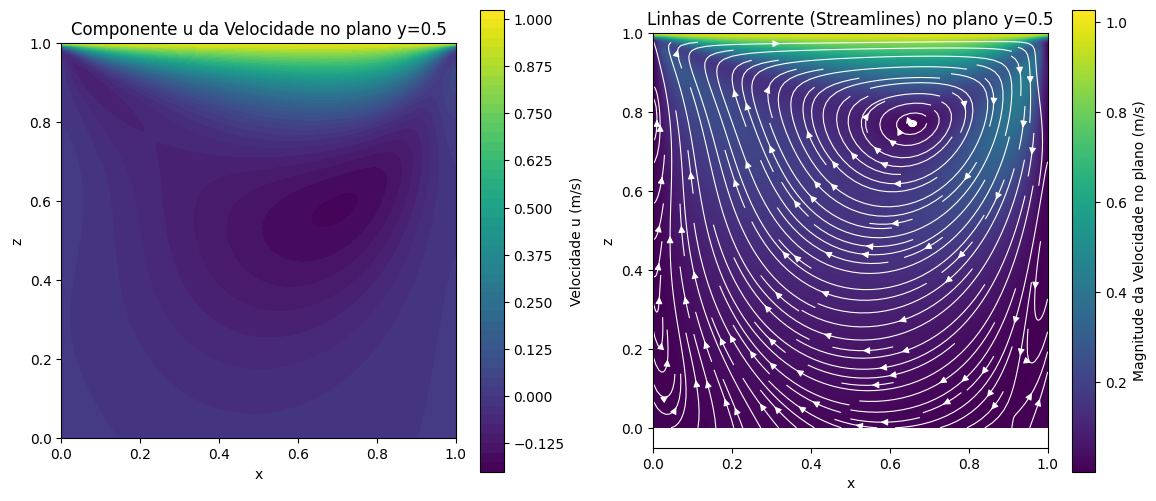

In [ ]:
# --- Passo 8: Visualizar os resultados ---
print("Treinamento concluído. Gerando visualizações...")

# Criar uma grade de pontos para plotar um corte no centro do cubo (plano y=0.5)
nx, nz = 101, 101
x_plot = np.linspace(0, 1, nx)
z_plot = np.linspace(0, 1, nz)
X, Z = np.meshgrid(x_plot, z_plot)

# Empilhar os pontos no formato correto para a predição
plot_points = np.hstack((X.flatten()[:, None], np.full((nx * nz, 1), 0.5), Z.flatten()[:, None]))
predictions = model.predict(plot_points)

# Separar as componentes da solução e redimensioná-las para o formato da grade
u = predictions[:, 0].reshape(nx, nz)
v = predictions[:, 1].reshape(nx, nz)
w = predictions[:, 2].reshape(nx, nz)
p = predictions[:, 3].reshape(nx, nz)

# Plotar o campo de velocidade 'u' e as linhas de corrente
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
contour = plt.contourf(X, Z, u, levels=50, cmap='viridis')
plt.colorbar(contour, label='Velocidade u (m/s)')
plt.title('Componente u da Velocidade no plano y=0.5')
plt.xlabel('x')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')


plt.subplot(1, 2, 2)
# A magnitude da velocidade no plano é usada para colorir o fundo
velocity_magnitude = np.sqrt(u**2 + w**2)
plt.imshow(velocity_magnitude, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', interpolation='bicubic')
plt.colorbar(label='Magnitude da Velocidade no plano (m/s)')
# As linhas de corrente são plotadas sobre o campo de magnitude
plt.streamplot(X, Z, u, w, color='white', density=1.5, linewidth=0.8)
plt.title('Linhas de Corrente (Streamlines) no plano y=0.5')
plt.xlabel('x')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
